In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm.auto import tqdm
import random, pickle, math, warnings
import itertools,  multiprocessing, json
from tqdm import tqdm
import matplotlib.pyplot as plt
#warnings.simplefilter('ignore')
print("CPU Count: ", multiprocessing.cpu_count())


/home/alberto/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU Count:  16


In [2]:
import gc
import os
from math import exp
from collections import Counter
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import transformers
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    model_path: str = '/kaggle/input/gemma-2/transformers/gemma-2-9b/2',
    load_in_8bit: bool = False,
    clear_mem: bool = False,
) -> float:
    """
    Calculates the mean perplexity of submitted text permutations compared to an original text.

    Parameters
    ----------
    solution : DataFrame
        DataFrame containing the original text in a column named 'text'.
        Includes a row ID column specified by `row_id_column_name`.

    submission : DataFrame
        DataFrame containing the permuted text in a column named 'text'.
        Must have the same row IDs as the solution.
        Includes a row ID column specified by `row_id_column_name`.

    row_id_column_name : str
        Name of the column containing row IDs.
        Ensures aligned comparison between solution and submission.

    model_path : str, default='/kaggle/input/gemma-2/transformers/gemma-2-9b/2'
        Path to the serialized LLM.

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    clear_mem : bool, default=False
        Clear GPU memory after scoring by clearing the CUDA cache.
        Useful for testing.

    Returns
    -------
    float
        The mean perplexity score. Lower is better.

    Raises
    ------
    ParticipantVisibleError
        If the submission format is invalid or submitted strings are not valid permutations.

    Examples
    --------
    >>> import pandas as pd
    >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["this is a normal english sentence", "the quick brown fox jumps over the lazy dog"]
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["sentence english normal a is this", "lazy the over jumps fox brown quick the dog"]
    ... })
    >>> score(solution, submission, 'id', model_path=model_path, clear_mem=True) > 0
    True
    """
    # Check that each submitted string is a permutation of the solution string
    sol_counts = solution.loc[:, 'text'].str.split().apply(Counter)
    sub_counts = submission.loc[:, 'text'].str.split().apply(Counter)
    invalid_mask = sol_counts != sub_counts
    if invalid_mask.any():
        raise ParticipantVisibleError(
            'At least one submitted string is not a valid permutation of the solution string.'
        )

    # Calculate perplexity for the submitted strings
    sub_strings = [
        ' '.join(s.split()) for s in submission['text'].tolist()
    ]  # Split and rejoin to normalize whitespace
    scorer = PerplexityCalculator(
        model_path=model_path,
        load_in_8bit=load_in_8bit,
    )  # Initialize the perplexity calculator with a pre-trained model
    perplexities = scorer.get_perplexity(
        sub_strings
    )  # Calculate perplexity for each submitted string

    if clear_mem:
        # Just move on if it fails. Not essential if we have the score.
        try:
            scorer.clear_gpu_memory()
        except:
            print('GPU memory clearing failed.')

    return float(np.mean(perplexities))


class PerplexityCalculator:
    """
    Calculates perplexity of text using a pre-trained language model.

    Adapted from https://github.com/asahi417/lmppl/blob/main/lmppl/ppl_recurrent_lm.py

    Parameters
    ----------
    model_path : str
        Path to the pre-trained language model

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    device_map : str, default="auto"
        Device mapping for the model.
    """

    def __init__(
        self,
        model_path: str,
        load_in_8bit: bool = False,
        device_map: str = 'auto',
    ):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)
        # Configure model loading based on quantization setting and device availability
        if load_in_8bit:
            if DEVICE.type != 'cuda':
                raise ValueError('8-bit quantization requires CUDA device')
            quantization_config = transformers.BitsAndBytesConfig(load_in_8bit=True)
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                quantization_config=quantization_config,
                device_map=device_map,
            )
        else:
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
                device_map=device_map,
            )

        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')

        self.model.eval()

    def get_perplexity(
        self, input_texts: Union[str, List[str]], debug=False
    ) -> Union[float, List[float]]:
        """
        Calculates the perplexity of given texts.

        Parameters
        ----------
        input_texts : str or list of str
            A single string or a list of strings.

        batch_size : int, default=None
            Batch size for processing. Defaults to the number of input texts.

        debug : bool, default=False
            Print debugging information.

        Returns
        -------
        float or list of float
            A single perplexity value if input is a single string,
            or a list of perplexity values if input is a list of strings.

        Examples
        --------
        >>> import pandas as pd
        >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
        >>> scorer = PerplexityCalculator(model_path=model_path)

        >>> submission = pd.DataFrame({
        ...     'id': [0, 1, 2],
        ...     'text': ["this is a normal english sentence", "thsi is a slihgtly misspelled zr4g sentense", "the quick brown fox jumps over the lazy dog"]
        ... })
        >>> perplexities = scorer.get_perplexity(submission["text"].tolist())
        >>> perplexities[0] < perplexities[1]
        True
        >>> perplexities[2] < perplexities[0]
        True

        >>> perplexities = scorer.get_perplexity(["this is a sentence", "another sentence"])
        >>> all(p > 0 for p in perplexities)
        True

        >>> scorer.clear_gpu_memory()
        """
        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts

        loss_list = []
        with torch.no_grad():
            # Process each sequence independently
            for text in input_texts:
                # Explicitly add sequence boundary tokens to the text
                text_with_special = f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}"

                # Tokenize
                model_inputs = self.tokenizer(
                    text_with_special,
                    return_tensors='pt',
                    add_special_tokens=False,
                )

                if 'token_type_ids' in model_inputs:
                    model_inputs.pop('token_type_ids')

                model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

                # Get model output
                output = self.model(**model_inputs, use_cache=False)
                logits = output['logits']

                # Shift logits and labels for calculating loss
                shift_logits = logits[..., :-1, :].contiguous()  # Drop last prediction
                shift_labels = model_inputs['input_ids'][..., 1:].contiguous()  # Drop first input

                # Calculate token-wise loss
                loss = self.loss_fct(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1)
                )

                # Calculate average loss
                sequence_loss = loss.sum() / len(loss)
                loss_list.append(sequence_loss.cpu().item())

                # Debug output
                if debug:
                    print(f"\nProcessing: '{text}'")
                    print(f"With special tokens: '{text_with_special}'")
                    print(f"Input tokens: {model_inputs['input_ids'][0].tolist()}")
                    print(f"Target tokens: {shift_labels[0].tolist()}")
                    print(f"Input decoded: {self.tokenizer.decode(model_inputs['input_ids'][0])}")
                    print(f"Target decoded: {self.tokenizer.decode(shift_labels[0])}")
                    print(f"Individual losses: {loss.tolist()}")
                    print(f"Average loss: {sequence_loss.item():.4f}")

        ppl = [exp(i) for i in loss_list]

        if debug:
            print("\nFinal perplexities:")
            for text, perp in zip(input_texts, ppl):
                print(f"Text: '{text}'")
                print(f"Perplexity: {perp:.2f}")

        return ppl[0] if single_input else ppl

    def clear_gpu_memory(self) -> None:
        """Clears GPU memory by deleting references and emptying caches."""
        if not torch.cuda.is_available():
            return

        # Delete model and tokenizer if they exist
        if hasattr(self, 'model'):
            del self.model
        if hasattr(self, 'tokenizer'):
            del self.tokenizer

        # Run garbage collection
        gc.collect()

        # Clear CUDA cache and reset memory stats
        with DEVICE:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            torch.cuda.reset_peak_memory_stats()

In [3]:
scorer = PerplexityCalculator('google/gemma-2-9b') #'~/.cache/huggingface/hub/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6')
scorer.get_perplexity("hello how are you"), scorer.get_perplexity("you are how hello")

/home/alberto/anaconda3/envs/torch/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Loading checkpoint shards: 100%|██████████| 8/8 [00:01<00:00,  6.42it/s]
Some parameters are on the meta device because they were offloaded to the disk and cpu.


(861.7769570533256, 68285.22831913295)

# Use GPT2 for perplexity

In [4]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

def calculate_perplexity(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")
    
    # Get logits from the model
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss  # The loss is the mean cross-entropy loss
    
    # Calculate perplexity
    perplexity = torch.exp(loss)
    return perplexity.item()


In [5]:
calculate_perplexity("hello how are you"), calculate_perplexity("you are how hello")

(90.3993148803711, 5412.56005859375)

# Genetic algorithm implementation

In [6]:
import random

In [7]:
#phrase = 'would just in happened town the what you not believe'
phrase = 'I am a computer science student and I am interested in learning new topics concerning natural language processing'
# I am new and I am a computer science student learning natural language processing in interested topics concerning
words = phrase.split(" ")

In [9]:
population_count = len(words) * 6

population = []

while len(population) < population_count:
    random.shuffle(words)
    add = True
    for w in population:
        if w["words"] == words:
            add = False
            break

    if add:
        population.append({
            "words": words.copy(),
            "fitness": calculate_perplexity(" ".join(words))
        })
population = sorted(population, key=lambda x: x["fitness"])
len(population)

108

In [10]:
# Implement order crossover

def get_average_fitness(population):
    total = 0
    for p in population:
        total += p["fitness"]
    return total/len(population)

def get_first_spot(parent):
    for i in range(len(parent)):
        if parent[i] == "":
            return i
    return len(parent)-1



In [11]:
get_average_fitness(population)

4607.380920410156

In [12]:
for el in population:
    if "" in el["words"]:
        print("Error")

In [13]:
averageFitness = []
bestFitness = []
MUTATION_RATE = 1
best = {"fitness": 1000000, "words": []}

In [14]:
def order_crossover(parent1, parent2):
    start_index = random.randint(0,len(parent1)-1)
    end_index = start_index + random.randint(1,len(parent1)-start_index) # non inclusive

    child = ["" for _ in range(len(parent1))]
    child[start_index:end_index] = parent1[start_index:end_index]

    # I have to put the words that aren't in child in the same order as they appear in parent2
    i = 0
    while i < len(parent1):
        word = parent2[i]
        if parent1.count(word) != child.count(word):
            # If this word is not present in the children, let's put it at the first available spot
            child[get_first_spot(child)] = word
        i += 1
    
    if "" in child:
        print("ERROR")

    return child


def mutate(el, how_many):
    for _ in range(how_many):
        i = random.randint(0,len(el)-1)
        j = random.randint(0,len(el)-1)
        
        el[i], el[j] = el[j], el[i]
        pass
    return el

for i in tqdm(range(30)):
    fitness = get_average_fitness(population)
    averageFitness.append(fitness)
    bestFitness.append(best["fitness"])
    print(fitness, best["fitness"], population[0]["fitness"], " ".join(population[0]["words"]))


    offspring = []
    if population[0]["fitness"] < best["fitness"]:
        best = population[0]

    pop_pick = [p["words"] for p in population]
    weights = [1/p["fitness"] for p in population]

    while len(offspring) < population_count:
        # TODO: use randomness with weight based on fitness
        
        p1_i = len(offspring)
        p2_i = len(offspring) + 1
        if p2_i >= len(population):
            p2_i = 0

        parent1 = population[p1_i]["words"]
        parent2 = population[p2_i]["words"]

        #parent1 = random.choices(pop_pick, weights)[0]
        #parent2 = random.choices(pop_pick, weights)[0]

        child = order_crossover(parent1, parent2)

        if random.randint(0,100) < MUTATION_RATE:
            child = mutate(child, random.choices([1,2,3,4], [0.4, 0.3, 0.2, 0.1])[0])

        offspring.append({
            "words": child.copy(),
            "fitness": calculate_perplexity(" ".join(child))
        })
    
    population = offspring.copy()
    population = sorted(population, key=lambda x: x["fitness"])
    
    fit_to_compare = population[0]["fitness"]
    for i in range(1, len(population)):
        if abs(population[i]["fitness"] - fit_to_compare) < 1:
            print("Entropy mutation")
            population[i]["words"] = mutate(population[i]["words"], random.choices([1,2,3,4], [0.4, 0.3, 0.2, 0.1])[0])
            population[i]["fitness"] = calculate_perplexity(" ".join(population[i]["words"]))
    
    population = sorted(population, key=lambda x: x["fitness"])

  0%|          | 0/30 [00:00<?, ?it/s]

4607.380920410156 1000000 1137.4462890625 processing and I am topics concerning new science I am a student language in interested computer natural learning


  3%|▎         | 1/30 [00:12<06:15, 12.96s/it]

4322.7921142578125 1137.4462890625 1218.7578125 topics I new interested am and a computer student in language processing science I am concerning natural learning


  7%|▋         | 2/30 [00:24<05:43, 12.28s/it]

4299.7134840223525 1137.4462890625 902.728515625 topics new I am interested a and computer student in language processing science I am concerning natural learning


 10%|█         | 3/30 [00:36<05:23, 11.98s/it]

4552.791856553819 902.728515625 1380.052734375 I am learning new language interested processing and I am a concerning student science topics in natural computer


 13%|█▎        | 4/30 [00:48<05:09, 11.92s/it]

4513.340336552373 902.728515625 986.9693603515625 topics new I am student in processing science I am concerning natural and a computer language interested learning


 17%|█▋        | 5/30 [01:01<05:12, 12.48s/it]

4379.819056193034 902.728515625 864.8132934570312 new topics student I am interested natural and concerning I am learning in computer language processing science a


 20%|██        | 6/30 [01:16<05:16, 13.21s/it]

4315.883417200159 864.8132934570312 1306.66748046875 topics new I am student processing I am science and a computer language interested concerning in natural learning


 23%|██▎       | 7/30 [01:31<05:20, 13.95s/it]

4090.4688681143302 864.8132934570312 935.2288208007812 language interested I am in natural processing a topics concerning computer science am student and learning new I


 27%|██▋       | 8/30 [01:43<04:54, 13.39s/it]

4157.390761198821 864.8132934570312 986.6734008789062 I topics I and interested computer science in am learning am student a concerning new natural language processing


 30%|███       | 9/30 [01:57<04:43, 13.49s/it]

4235.623614275897 864.8132934570312 1058.653076171875 new computer student topics and a natural science concerning I am I interested in am processing language learning


 33%|███▎      | 10/30 [02:10<04:27, 13.35s/it]

4260.17583211263 864.8132934570312 706.0440063476562 am processing topics concerning I am I language computer science and new student interested in learning a natural


 37%|███▋      | 11/30 [02:23<04:07, 13.02s/it]

4090.9089683250145 706.0440063476562 912.1956787109375 am I student in natural science and a interested computer am I processing concerning topics new language learning


 40%|████      | 12/30 [02:36<03:54, 13.03s/it]

3864.3409672489875 706.0440063476562 647.4132080078125 computer I am topics learning I am processing science in a new interested student language and concerning natural


 43%|████▎     | 13/30 [02:48<03:40, 12.97s/it]

3706.798225685402 647.4132080078125 814.3612060546875 a natural processing topics I am concerning I am language science computer and new student interested in learning


 47%|████▋     | 14/30 [03:01<03:24, 12.79s/it]

3667.8420184100114 647.4132080078125 860.2160034179688 I am student new learning I am interested and natural in language computer science a topics concerning processing


 50%|█████     | 15/30 [03:14<03:14, 12.96s/it]

3641.056849726924 647.4132080078125 667.52685546875 am I natural I am language and new student interested in learning computer science a topics concerning processing


 53%|█████▎    | 16/30 [03:28<03:04, 13.21s/it]

3640.0968424479165 647.4132080078125 1130.2625732421875 I topics am processing a natural concerning I am language science computer and new student interested in learning


 57%|█████▋    | 17/30 [03:42<02:53, 13.35s/it]

3743.5293353045427 647.4132080078125 1052.9686279296875 am I student am I new interested in natural and processing science learning a computer topics concerning language


 60%|██████    | 18/30 [03:54<02:38, 13.18s/it]

3834.902577718099 647.4132080078125 941.8980712890625 am I am I natural language and interested computer science a student processing in new topics concerning learning


 63%|██████▎   | 19/30 [04:07<02:22, 12.92s/it]

3812.4582316080728 647.4132080078125 1059.57275390625 am I student am I new interested in natural and processing science a computer language topics concerning learning


 67%|██████▋   | 20/30 [04:20<02:10, 13.09s/it]

3872.4023154929832 647.4132080078125 943.97216796875 am I student am I new interested in natural and processing science a computer language concerning learning topics


 70%|███████   | 21/30 [04:32<01:54, 12.76s/it]

3814.1299449779367 647.4132080078125 1035.9061279296875 I I am natural a student processing language and am concerning interested in new topics science computer learning


 73%|███████▎  | 22/30 [04:46<01:44, 13.01s/it]

3838.352955005787 647.4132080078125 1177.1632080078125 I I am learning processing topics in natural language interested student computer science concerning and new am a


 77%|███████▋  | 23/30 [05:00<01:33, 13.34s/it]

3882.803247522425 647.4132080078125 985.325927734375 am I natural interested I student in processing topics concerning language am computer science and learning a new


 80%|████████  | 24/30 [05:12<01:18, 13.08s/it]

3749.8740189163773 647.4132080078125 543.7333984375 learning I am a natural student in processing topics concerning language am computer science and interested new I


 83%|████████▎ | 25/30 [05:26<01:05, 13.15s/it]

3821.817541051794 543.7333984375 1202.242919921875 I am interested processing new computer I am in student natural language concerning topics learning a science and


 87%|████████▋ | 26/30 [05:38<00:51, 12.97s/it]

4029.865429348416 543.7333984375 688.9401245117188 I natural student I am processing interested in a new am topics computer science language and learning concerning


 90%|█████████ | 27/30 [05:51<00:38, 12.84s/it]

4027.195383142542 543.7333984375 688.9401245117188 I natural student I am processing interested in a new am topics computer science language and learning concerning


 93%|█████████▎| 28/30 [06:03<00:25, 12.82s/it]

3928.717931676794 543.7333984375 743.8931884765625 I am processing new I am a computer science and topics student concerning interested learning in natural language


 97%|█████████▋| 29/30 [06:16<00:12, 12.81s/it]

3863.992367779767 543.7333984375 620.3921508789062 I natural processing I am am interested a new in student learning concerning topics computer science and language


100%|██████████| 30/30 [06:29<00:00, 12.98s/it]


computer natural language processing and I science in a student learning interested concerning topics I am am new


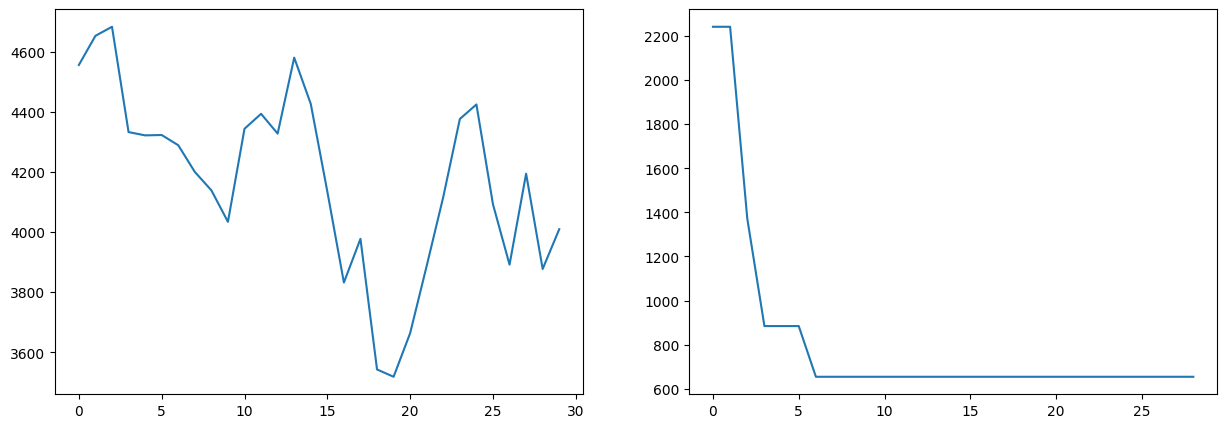

In [95]:
print(" ".join(best["words"]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(averageFitness)
# plt.subplot(1,2,2)
plt.plot(bestFitness[1:])

In [72]:
get_average_fitness(offspring)

3310.8373345269097

In [83]:
i=10
population[i]["fitness"], " ".join(population[i]["words"])

(2833.216064453125,
 'I am am new I topics and a computer natural interested science student language concerning processing in learning')

In [28]:
start_index, end_index

NameError: name 'start_index' is not defined

In [ ]:
parent1[0:1]

In [ ]:
population